# AdventureWorks Sales Analysis


In [ ]:
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

user = "SA"
password = quote_plus("Rallelek123")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Connection to the database was successful!")
except Exception as e:
    print("There was an error", e)

def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)
    
DATA_DIR = Path("..") / "data"

def read_sql_file(filename: str) -> str:
    return (DATA_DIR / filename).read_text(encoding="utf-8")

def sek(x, pos):
    return f"{x:,.0f} SEK".replace(",", " ")

sek_formatter = FuncFormatter(sek)

def add_bar_labels(ax, fmt="{:,.0f}", pad=3):
    for c in ax.containers:
        ax.bar_label(c, fmt=fmt, padding=pad)

def add_bar_labels_simple(bars, ax, fmt="{:,.0f}", pad=3):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + pad, fmt.format(h), 
                ha='center', va='bottom')

# Visualisation 1 - Number of products per category
**Business question:** How many products exists in each product category?  
**Method:** Join ProductCategory -> ProductSubcategory -> Product and count distinct products per category.

In [ ]:
sql = read_sql_file("vis1.sql")
df1 = query_df(sql)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df1['CategoryName'], df1['TotalProducts'], edgecolor='black', alpha=0.8)

add_bar_labels_simple(bars, ax, fmt="{:,.0f}")
ax.set_title("Number of Products per Category", fontsize=16)
ax.set_xlabel("Product Category", fontsize=12)
ax.set_ylabel("Number of Products", fontsize=12)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

## Insights
The category with the most products is components with 134 products, while accessories has the fewest with 29 products.  
This indicates that the company is strongly focused on components and spare parts, and that accessories could be an area for improvement/development.

# Visualisation 2 - Total sales per category
**Business question:** Which product categories generate the most revenue?  
**Method:** Join categories to SalesOrderDetail and sum 'LineTotal'. Sorted from highest to lowest.

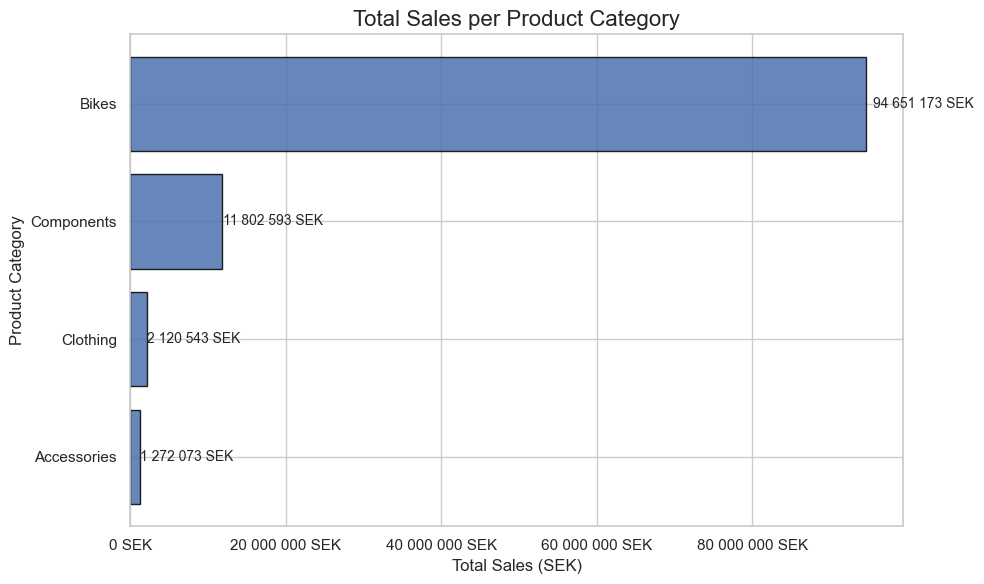

In [31]:
sql = read_sql_file("vis2.sql")
df2 = query_df(sql)

fix, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(df2['CategoryName'][::-1], df2['TotalSales'][::-1], edgecolor='black', alpha=0.85)

for bar in bars:
    width = bar.get_width()
    ax.text(width * 1.01, bar.get_y() + bar.get_height() / 2, f"{width:,.0f} SEK".replace(",", " "), 
            ha='left', va='center', fontsize=10)
    

ax.set_title("Total Sales per Product Category", fontsize=16)
ax.set_xlabel("Total Sales (SEK)", fontsize=12)
ax.set_ylabel("Product Category", fontsize=12)
ax.xaxis.set_major_formatter(sek_formatter)

plt.tight_layout()
plt.show()

## Insights
The top category is Bikes with 94.65 million SEK in revenue. The smallest is Acessories with 1,27 million SEK.

Bikes account for most of the revenue & total sales (aprox 86% of total sales). The 3 other categories only amount to 14% of revenue. This can help prioritize which categories drive most of the business revenue and which could use more attention.

# Visualisation 3 - Monthly sales trend
**Business question:** How has sales developed over time?  
**Method:** Aggregate 'TotalDue' per month from SalesOrderHeader and plot a time series.

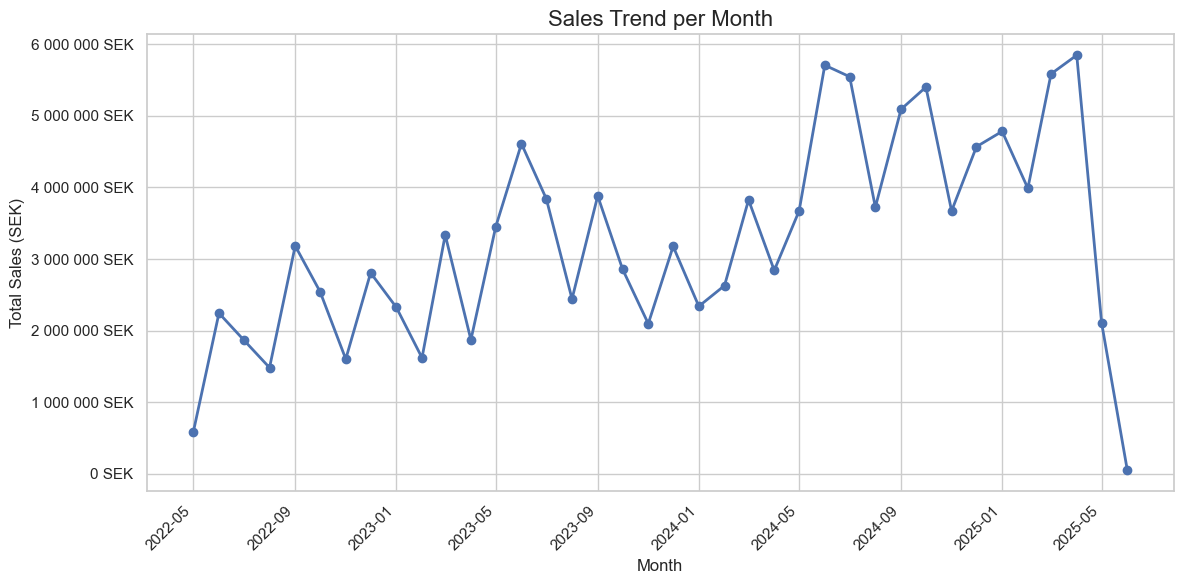

In [34]:
sql = read_sql_file("vis3.sql")
df3 = query_df(sql)

df3['MonthStart'] = pd.to_datetime(df3['MonthStart'])
df3 = df3.sort_values('MonthStart')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df3['MonthStart'], df3['TotalSales'], marker='o', linewidth=2)

ax.set_title("Sales Trend per Month", fontsize=16)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Total Sales (SEK)", fontsize=12)
ax.yaxis.set_major_formatter(sek_formatter)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Insights
The graph shows a clear upward trend in total monthly sales over time, indicating steady business growth.

Sales start at a relatively low level in mid 2022 and then increase gradually all throughout 2023, with noticeable fluctuations from month to month.
2024 onwards, sales reach consistently higher levels, with several months exceeding 5 million SEK.

There also appears to be a seasonal pattenr, where sales tend to peak during certain periods of the year, followed by temporary declines. The highest monthly sales occur in early 2025, while the lowest values are observed at the beginning of graph in 2022.

# Visualisation 4 - Sales and order count per year (grouped)
**Business question:** How do total sales and number of orders compare per year?  
**Method:** Group SalesOrderHeader by year, calculate total sales and count orders.

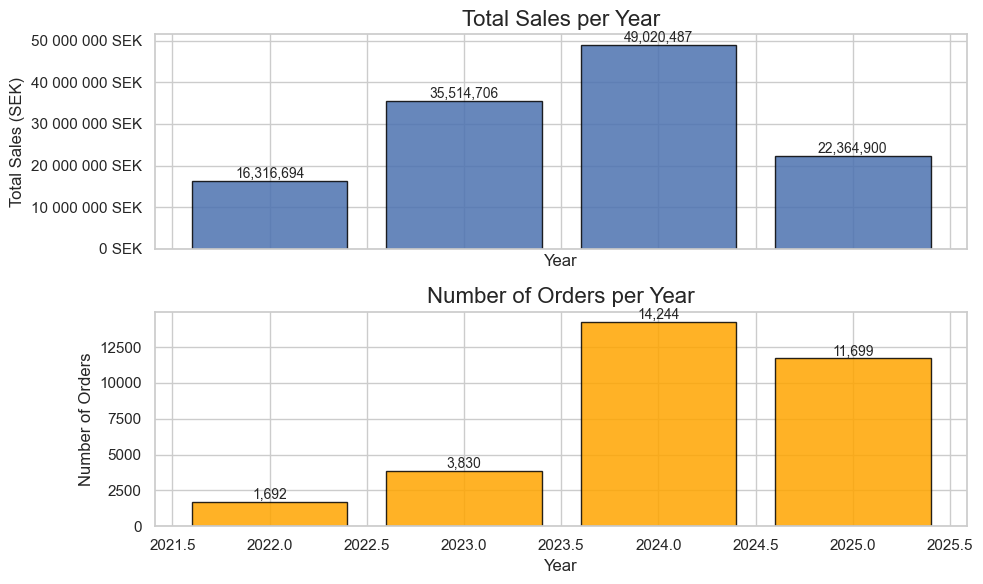

In [39]:
sql = read_sql_file("vis4.sql")
df4 = query_df(sql)
df4 = df4.sort_values('OrderYear')

fig, axes = plt.subplots(2,1,figsize=(10, 6), sharex=True)

#Plot 1
bars_sales = axes[0].bar(df4['OrderYear'], df4['TotalSales'], edgecolor='black', alpha=0.85)

axes[0].set_title("Total Sales per Year", fontsize=16)
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("Total Sales (SEK)")
axes[0].yaxis.set_major_formatter(sek_formatter)

for bar in bars_sales:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f"{height:,.0f}", ha='center', va='bottom', fontsize=10)

#Plot 2
bars_orders = axes[1].bar(df4['OrderYear'], df4['OrderCount'], color='orange', edgecolor='black', alpha=0.85)

axes[1].set_title("Number of Orders per Year", fontsize=16)
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_ylabel("Number of Orders", fontsize=12)

for bars in bars_orders:
    height = bars.get_height()
    axes[1].text(bars.get_x() + bars.get_width() / 2, height, f"{height:,.0f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Insights
- Both total sales and the numbers of orders increase from 2022 to 2024, indicating very strong business growth.  
- 2024 is the strongest year, with bot hthe highest sales (49m SEK) and the highest number of orders (14000).  
- in 2025, total sales decrease despite a relatively high number of orders. This is very likely because 2025 only represents a partial year, not a full 12-month period.  
- Overall, the trend shows that growth in sales is largely driven by an increase in order volume rather than a decrease in demand.

# Visualisation 5 - Top 10 products by sales
**Business question:** Which 10 products generate the most sales?  
**Method:** Sum LineTotal per product in SalesOrderDetail and keep TOP 10.